In [ ]:
import tarfile

with tarfile.open('/content/dtd-r1.0.1.tar.gz', 'r:gz') as tar:
    tar.extractall(path='/content/dtd')

In [ ]:
!pip install scikit-image==0.19.3

In [ ]:
!pip install tensorflow==2.9

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 32.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 24.3.25
    Uninstalling flatbuffers-24.3.25:
      Successfully uninstalled flatbuffers-24.3.25
  Attempting uninstall: tensorboard-data-serve

In [ ]:
!pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
# Define dataset path and parameters
data_dir = '/content/dtd/dtd/images'
img_size = (128, 128)
images, labels = [], []

In [ ]:
# Load images and labels with error handling
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    for img_file in os.listdir(label_dir):
        img_path = os.path.join(label_dir, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(label)
        else:
            print(f"Warning: Unable to load image at {img_path}")

images = np.array(images)
labels = np.array(labels)

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_encoded = to_categorical(labels_encoded)

In [ ]:
# Reshape images for CNN
images = images.reshape(-1, img_size[0], img_size[1], 1)

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2
)

In [ ]:
# Transfer Learning with VGG16
def build_transfer_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        base_model,
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

transfer_model = build_transfer_model((128, 128, 3), y_train.shape[1])

In [ ]:
# Reshape to match VGG16 input (3 channels)
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

history = transfer_model.fit(datagen.flow(X_train_rgb, y_train, batch_size=32),
                             validation_data=(X_test_rgb, y_test),
                             epochs=15)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


141/141 ━━━━━━━━━━━━━━━━━━━━ 1255s 9s/step - accuracy: 0.0218 - loss: 13.2220 - val_accuracy: 0.0408 - val_loss: 4.0500
Epoch 2/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 1248s 9s/step - accuracy: 0.0263 - loss: 3.9754 - val_accuracy: 0.0479 - val_loss: 3.8945
Epoch 3/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 1237s 9s/step - accuracy: 0.0347 - loss: 3.8999 - val_accuracy: 0.0629 - val_loss: 3.8217
Epoch 4/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 1257s 9s/step - accuracy: 0.0363 - loss: 3.8556 - val_accuracy: 0.0621 - val_loss: 3.7711
Epoch 5/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 1262s 9s/step - accuracy: 0.0380 - loss: 3.8380 - val_accuracy: 0.0603 - val_loss: 3.7409
Epoch 6/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 1252s 9s/step - accuracy: 0.0443 - loss: 3.8088 - val_accuracy: 0.0807 - val_loss: 3.7127
Epoch 7/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 1241s 9s/step - accuracy: 0.0472 - loss: 3.8074 - val_accuracy: 0.0842 - val_loss: 3.6548
Epoch 8/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 1222s 9s/step - accuracy: 0.0495 - loss: 3.7526 - val_accura

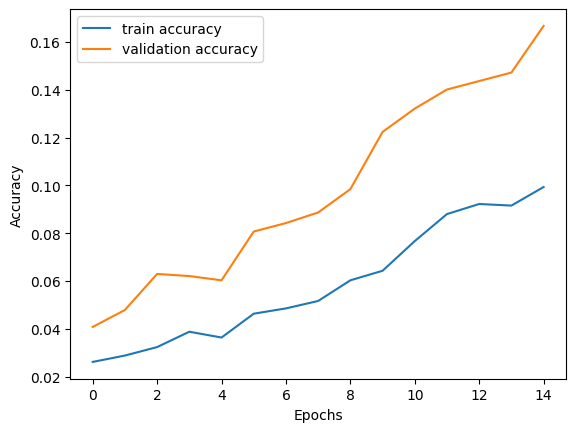

In [ ]:
# Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Sample Test Images Predictions:


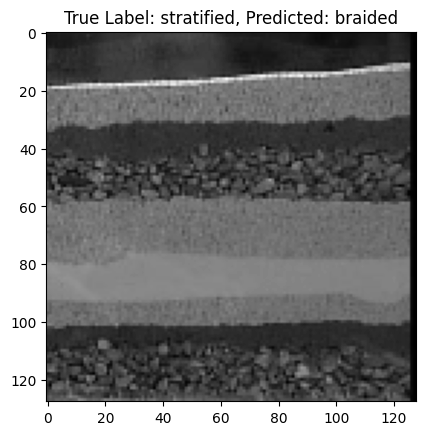

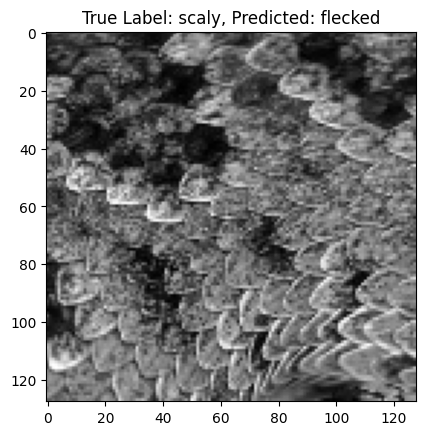

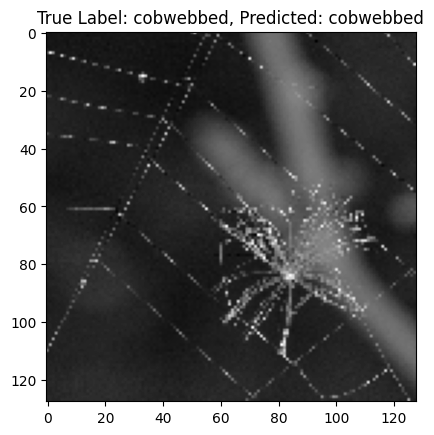

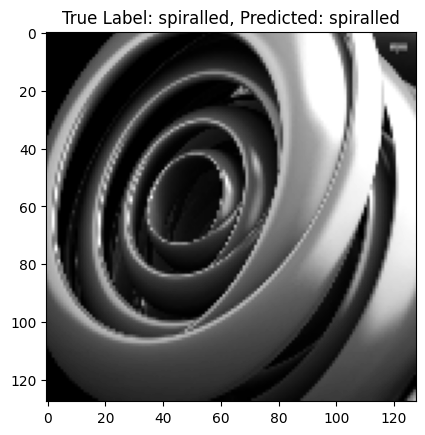

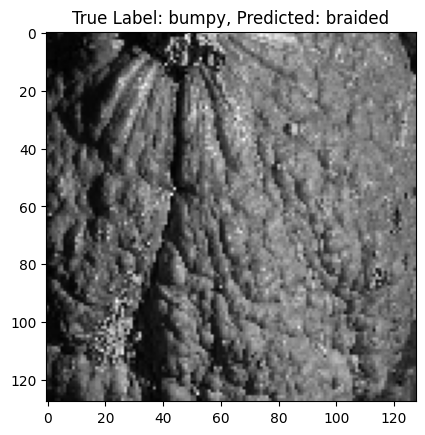

In [ ]:
# Predictions for Sample Output
sample_test_images = X_test[:5]
sample_labels = np.argmax(y_test[:5], axis=1)
predicted_labels = np.argmax(transfer_model.predict(np.repeat(sample_test_images, 3, axis=-1)), axis=1)

print("Sample Test Images Predictions:")
for i in range(5):
    plt.imshow(sample_test_images[i].reshape(img_size[0], img_size[1]), cmap='gray')
    plt.title(f"True Label: {label_encoder.inverse_transform([sample_labels[i]])[0]}, Predicted: {label_encoder.inverse_transform([predicted_labels[i]])[0]}")
    plt.show()